<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://colab.research.google.com/drive/199SxVBGDdkuzSzU9pjVP9BfMPzaypLfj#scrollTo=UUSaBpguVsBB




In [ ]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])   #一様分布からサンプリング
        print(f'prob: {self.prob}')

    def play(self, arm):
        if self.prob[arm] > random.random():
            return 1.0
        else:
            return 0.0

In [ ]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    基準値alephの更新
    RS-greedy選択肢を試行する
    """

    def __init__(self, K):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = 1.2        #必ず非満足状態になるように

    def initialize(self):
        self._V = np.array([0.5] * self._K)     #Vの初期値は0.5
        self._n = np.array([1e-8] * self._K)      #RS式でゼロ除算を防ぐため, sys.float_info.minでエラーになる可能性がある
        self._N = 0     #総試行回数
        self.RS = np.zeros(self._K)     #?. RSの初期値はゼロ？？
        # self._alpha = np.zeros(self._K)     #?. alphaは各腕n(a_i)によって分けるべきなのか？ a.多分そんなことしなくていい。

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + self._alpha * reward
        self._n[arm] += 1       #?. n(a_i)+=1の処理を先に行わないとハズレの場合、初期値V(a_i)=0.5が更新されてゼロになるので良くないのでは？
        self._N += 1
        self.RS[arm] = (self._n[arm] / self._N) * (self._V[arm] - self.aleph)     #RS評価値の更新(これは後で分ける？)

    def update_aleph(self):
        #2本腕を想定
        max_V = np.amax(self._V)
        mI = random.choice(np.where(self._V == max_V)[0])       #複数あった場合エラー吐く  a.多分解決した？
        if mI == 0: nmI = 1     #このコードは直せ mI:(maxIndex), nmI:(NotMaxIndex)
        else: nmI = 0
        upper = 1 - (self._V[nmI]/self._V[mI]) * (self._n[nmI]/self._n[mI])     #腕の確率が小さいと V(a_G) = V(a_j) = 0 でエラーになる可能性がある(一度も当たらない(かなりレアケース))
        lower = (1 - self._n[nmI]/self._n[mI])
        self.aleph = max_V * upper / lower      #step数が小さいと upper = lower になる可能性がある

    def select_arm(self):
        maxRS = np.amax(self.RS)        #ここの処理は違うメソッドに(後で書き換えて)
        maxIndex = np.where(self.RS == maxRS)[0]
        return random.choice(maxIndex)

In [ ]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._agent = RSAgent(K)
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._regret = np.zeros((trial, step))

    def run(self):
        for t in range(self._trial):
            print(f'{t}: aleph={self._agent.aleph}')
            self._env = Environment(K)      #腕の確率を生成
            self._prob = self._env.prob
            self._agent.initialize()
            for s in range(self._step):
                arm = self._agent.select_arm()
                reward = self._env.play(arm)
                self._agent.update(arm, reward)
                self.calc_regret(t, s, arm)
            self._agent.update_aleph()
            print(f'RS: {self._agent.RS}')
            print()
        self.print_regret()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] += np.amax(self._prob) - self._prob[arm]
        if s != 0: self._regret[t][s] += self._regret[t][s-1]

    def print_regret(self):
        plt.plot(np.arange(self._step), np.mean(self._regret, axis=0), label='RS', linestyle='dashed')
        plt.xlabel('steps')
        plt.ylabel('regret')
        plt.legend()
        plt.show()

0: aleph=1.2
prob: [0.77885816 0.49396118]
RS: [-0.42538    -1.20000001]

1: aleph=0.774654930986196
prob: [0.93211864 0.59980064]
RS: [ 0.15655917 -0.07382856]

2: aleph=0.9322476879774831
prob: [0.59583337 0.17941436]
RS: [-0.29375302 -0.31627468]

3: aleph=0.6616329664704383
prob: [0.91725059 0.38547006]
RS: [ 0.2564332  -0.66163297]

4: aleph=0.9181836367273449
prob: [0.26594935 0.463096  ]
RS: [-0.46684631 -0.45899   ]

5: aleph=0.45879286143974024
prob: [0.16902937 0.56425832]
RS: [-0.18351714  0.1045989 ]

6: aleph=0.5635254101640638
prob: [0.05440316 0.29733136]
RS: [-0.25266348 -0.20736398]

7: aleph=0.38962987662554116
prob: [0.01216125 0.08272281]
RS: [-0.38962988 -0.29999091]

8: aleph=0.08961792358471632
prob: [0.76809384 0.8333518 ]
RS: [0.67668208 0.        ]

9: aleph=0.7663000000000023
prob: [0.11118999 0.2898447 ]
RS: [-0.7663     -0.47662337]

10: aleph=0.2896579315863167
prob: [0.72396883 0.14818788]
RS: [ 0.43077103 -0.28965793]

11: aleph=0.720544108821762
prob: [

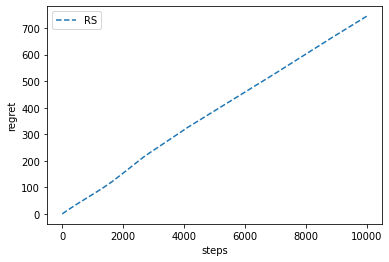

In [ ]:
trial = 50
step = 10000      #step数が少ないと n(a_G)=n(a_j) になりaleph更新式がゼロ除算を行ってエラーになる可能性がある
K = 2
sim = Simulator(trial, step, K)
sim.run()